In [ ]:
# A bit of setup
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Create color maps
cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
cmap_bold = ['darkorange', 'c', 'darkblue']

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [ ]:
## Generate data!

np.random.seed(111)

N = 1000 # number of points per class
D = 2 # dimensionality
K = 2 # number of classes

X = np.zeros((N*K,D))
y = np.zeros(N*K, dtype='uint8')



easy = 1  #set this to 1/True to have an easier data sample to train on
slopeDiff = 0.0
offsetDiff = 0.25

min = -1
max = 1
if easy:
    min = -0.5
    max = 1.5
    
for j in range(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.0,1,N) # radius
    t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
    xx = r*np.sin(t)
    yy = r*np.cos(t)
    if easy:
        xx = np.linspace(0,1,N)
        yy = (0.5+0.5*slopeDiff*(j+1))*xx + np.random.randn(N)*(0.05+j*0.05) + j*offsetDiff
    
    X[ix] = np.c_[xx,yy]
    y[ix] = j

#print("Design\n",X)
#print("labels\n",y)

fig = plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim([min,max])
plt.ylim([min,max])

**Fisher's Linear Discriminant Analysis**

Recall we have the ansatz:

$t(\vec{x}) = \sum{i=1}^{n} a_i x_i$

Fisher's insight tells us to minimize:

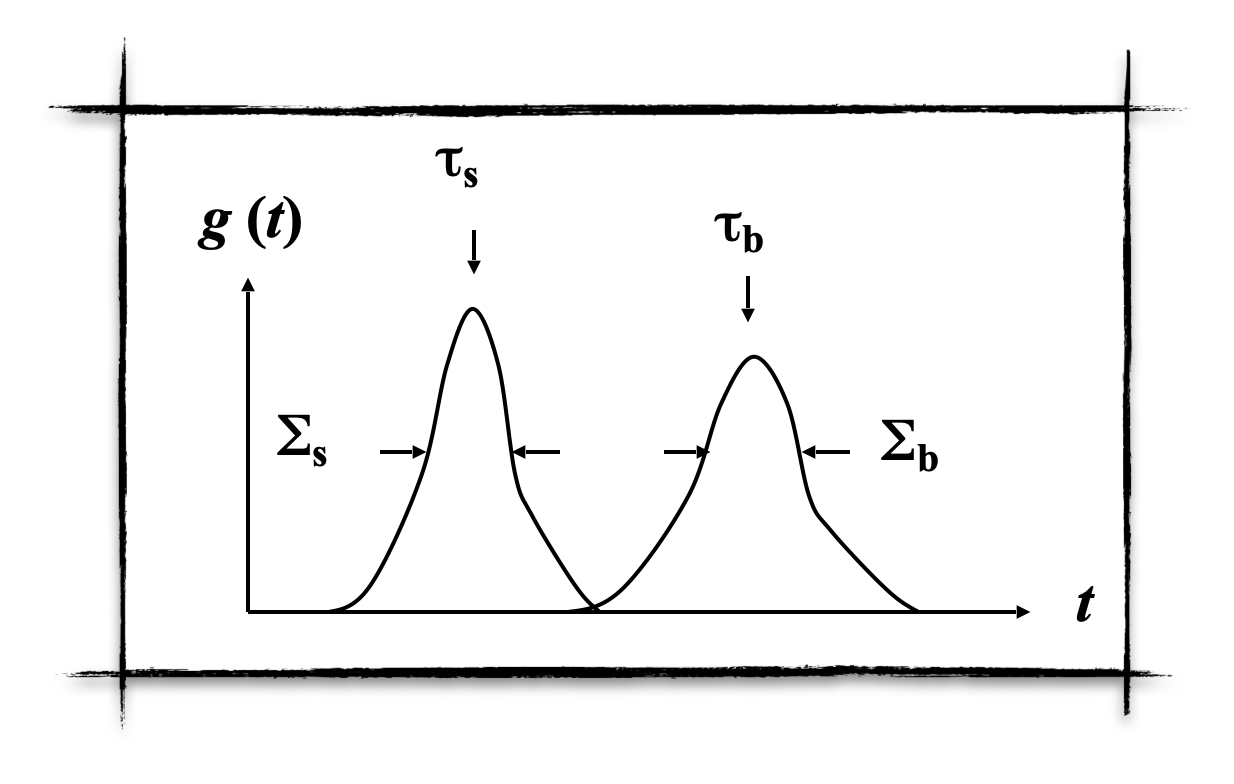

$J(\vec{a}) = {(\tau_s - \tau_b)^2 \over (\sigma^2_s + \sigma^2_b)}$

$J(\vec{a}) = { \vec{a}^T B \vec{a}  \over \vec{a}^T W \vec{a}}$



**Now some math!**

Consider this problem from the perspective of a Lagrangian, wherein we can ask for

$\max_{a} \vec{a}^T B \vec{a}$

for fixed

$\vec{a}^T W \vec{a} = C$

In Lagrangian form, we can write:

$L = \vec{a}^T B \vec{a} - \lambda \left(\vec{a}^T W \vec{a} - C\right)$

and thus we maximize by setting the derivative to zero:

${\partial L \over \partial \vec{a}} = B\vec{a} - \lambda W \vec{a} = 0$

or 

$B\vec{a} = \lambda W \vec{a}$

This is called a generalized Eigenvalue problem and can be written as:

$W^{-1} B \vec{a}-\lambda \vec{a}=0$

Let's write this in matrix form to show that we're not trying to subtract a scalar from a matrix!

$W^{-1} B \vec{a}-\lambda {\bf I}\vec{a}=0$



**Super, what are W and B??**

The matrix W is VERY close to the covariance matrix, but we do not want to divide by the total number of elements.

$W = \sum_{classes, c}\sum_{j\in c} \left(x_j - \mu_c\right)\left(x_j - \mu_c\right)^T$

The matrix B represents how far each population is from the global mean:

$B = \sum_{classes, c} N_c \left(\mu_c - \mu_g\right)\left(\mu_c - \mu_g\right)^T$

In [ ]:
meanAll = np.zeros((1,D))
meanClass = np.zeros((K,D))

for i in np.arange(K):
    for j in np.arange(D):
        meanClass[i,j] = np.mean(X[y==i,j])
                             
print("\nClass mean matrix:\n ",meanClass)

for j in np.arange(D):
        meanAll[0,j] = np.mean(X[:,j])
        
print("\nMean values of the full population:\n ", meanAll)

In [ ]:
#Calculate between and within matrices

scatBetween = np.zeros((1,D))
scatWithin = np.zeros((K,D))

for i in np.arange(K):
    for j in np.arange(D):
        XX = X[y==i,j] - meanClass[i,j]
        for k in np.arange(D):            
            YY = X[y==i,k] - meanClass[i,k]
            scatWithin[j,k] += np.sum(np.dot(XX,YY.T))

print("\n The within matrix W:\n",scatWithin)


scatBetween = np.dot(N*(meanClass - meanAll),(meanClass - meanAll).T)
print("\nThe between matrix B:\n",scatBetween)

**Linear Algebra enters the chat...**

We want to solve:

$W^{-1} B \vec{a}-\lambda {\bf I}\vec{a}=0$

which means we need the eigenvalues and eigenvectors for 

$W^{-1} B$



In [ ]:
eigval, eigvec = np.linalg.eig(np.dot(np.linalg.inv(scatWithin),scatBetween))

print("\nEigen values: ",eigval)
print("\nEigen vectors:\n",eigvec)

In [ ]:

# Transform the data to our new space with Y = X*w

Y = X.dot(eigvec)


In [ ]:
# Plot our data in this new space!
fig = plt.figure()
plt.scatter(Y[:, 1], Y[:, 0], c=y, s=40, cmap=plt.cm.Spectral)


In [ ]:
# Let's look at the marginal distribution
# IE, we are interested in the projection along a single axis
# This gives us the final test statistic format

# We will histogram now for easy viewing, so make bins
bins = np.linspace(-0.6,0.2,100)

# Plot in those bins
plt.hist(Y[y==0,1],bins,alpha=0.5)
plt.hist(Y[y==1,1],bins,alpha=0.5)
plt.show()



In [ ]:
## Now let's treat this like a hypothesis test
## Let's fix the size of the test to be 5% then
## work out what the power of the test will be

alpha = 0.05

tCut = -0.1
increment = 0.0001
fraction = 1

while fraction > alpha:
    tCut += increment
    fraction = np.count_nonzero(Y[y==1,1]>tCut)/np.count_nonzero(Y[y==1,1])
    
print("tCut = ",tCut)
print("alpha = ",fraction)
print("beta = ",1-np.count_nonzero(Y[y==0,1]>tCut)/np.count_nonzero(Y[y==0,1]))
